# Airbnb Analysis: Extra Credit Edition

## Overview
This notebook contains a comprehensive analysis of Airbnb listings across multiple cities (Austin, Chicago, Santa Cruz, Washington DC). We go beyond basic descriptive statistics to implement advanced data processing and machine learning workflows.

### Key Objectives:
1.  **Panel Data Construction**: Merging listing attributes with nightly calendar availability to create a granular dataset.
2.  **Seasonality Analysis**: Visualizing temporal trends to understand how prices and booking rates fluctuate by month and day of week.
3.  **Advanced Preprocessing**: Implementing a strict **Temporal Train-Validation-Test Split** (Jan-Sep / Oct-Nov / Dec-Feb) to realistically simulate forecasting and prevent data leakage.
4.  ** predictive Modeling**: Training and comparing **XGBoost** and **TensorFlow Neural Networks** to predict nightly prices (`price`) and booking probability (`is_booked`).
5.  **Performance Auditing**: Utilizing **TensorBoard** for real-time training monitoring and generating verified performance metrics (MAE/RMSE for regression, ROC-AUC/Accuracy for classification).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as pd_tf # naming to avoid conflict if needed, but standard is tf
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score
import datetime
import os

# Load TensorBoard extension
%load_ext tensorboard

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
USE_SAMPLE = True # Set to True to use a sample of data for faster execution during testing
SAMPLE_SIZE = 2000 # Recommended size for Colab. Set to False for full dataset analysis.


/Users/akshaymohanrevankar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Part 1: Build the Night-Level Panel Dataset

In this section, we construct our primary dataset. We load listings and calendar data from direct URLs for four major cities. To ensure efficient processing within memory constraints, we implement logical sampling and merge these disparate sources into a single, cohesive night-level panel dataframe.

In [2]:
data_urls = {
    "Austin": {
        "listings": "https://data.insideairbnb.com/united-states/tx/austin/2025-03-06/data/listings.csv.gz",
        "calendar": "https://data.insideairbnb.com/united-states/tx/austin/2025-03-06/data/calendar.csv.gz"
    },
    "Chicago": {
        "listings": "https://data.insideairbnb.com/united-states/il/chicago/2025-03-11/data/listings.csv.gz",
        "calendar": "https://data.insideairbnb.com/united-states/il/chicago/2025-03-11/data/calendar.csv.gz"
    },
    "Santa Cruz": {
        "listings": "https://data.insideairbnb.com/united-states/ca/santa-cruz-county/2025-03-28/data/listings.csv.gz",
        "calendar": "https://data.insideairbnb.com/united-states/ca/santa-cruz-county/2025-03-28/data/calendar.csv.gz"
    },
    "Washington DC": {
        "listings": "https://data.insideairbnb.com/united-states/dc/washington-dc/2025-03-13/data/listings.csv.gz",
        "calendar": "https://data.insideairbnb.com/united-states/dc/washington-dc/2025-03-13/data/calendar.csv.gz"
    }
}

def clean_price(price_str):
    if isinstance(price_str, str):
        return float(price_str.replace('$', '').replace(',', ''))
    return price_str

def load_and_merge(city_name, urls):
    print(f"Processing {city_name}...")
    
    # Load Listings
    listings = pd.read_csv(urls['listings'], compression='gzip', low_memory=False)
    listings['city'] = city_name
    
    # Select relevant columns to save memory
    listing_cols = ['id', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'host_is_superhost']
    listings = listings[listing_cols].rename(columns={'id': 'listing_id'})
    
    # Sampling for performance if enabled
    if USE_SAMPLE and len(listings) > SAMPLE_SIZE:
        listings = listings.sample(n=SAMPLE_SIZE, random_state=42)
    
    # Load Calendar
    calendar = pd.read_csv(urls['calendar'], compression='gzip', low_memory=False)
    
    # Filter calendar to only include sampled listings
    calendar = calendar[calendar['listing_id'].isin(listings['listing_id'])]
    
    # Merge
    # Left join calendar with listings
    df = pd.merge(calendar, listings, on='listing_id', how='left')
    df['city'] = city_name
    
    return df

all_data = []
for city, links in data_urls.items():
    city_df = load_and_merge(city, links)
    all_data.append(city_df)

panel_df = pd.concat(all_data, ignore_index=True)
print(f"Total Panel Data Shape: {panel_df.shape}")
panel_df.head()

Processing Austin...


Processing Chicago...


Processing Santa Cruz...


Processing Washington DC...


Total Panel Data Shape: (2803295, 15)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,review_scores_rating,host_is_superhost,city
0,5456,2025-03-13,t,$95.00,NaN,2.0,90.0,78702,Entire home/apt,3,1.0,2.0,4.85,t,Austin
1,5456,2025-03-14,f,$95.00,NaN,2.0,90.0,78702,Entire home/apt,3,1.0,2.0,4.85,t,Austin
2,5456,2025-03-15,f,$95.00,NaN,2.0,90.0,78702,Entire home/apt,3,1.0,2.0,4.85,t,Austin
3,5456,2025-03-16,f,$95.00,NaN,2.0,90.0,78702,Entire home/apt,3,1.0,2.0,4.85,t,Austin
4,5456,2025-03-17,f,$95.00,NaN,2.0,90.0,78702,Entire home/apt,3,1.0,2.0,4.85,t,Austin


### 1.2 Feature Engineering and Cleaning

Raw data requires cleaning before analysis. Here we:
- **Clean Prices**: Remove currency symbols ('$') and commas to convert pricing data into numerical floats.
- **Engineer 'is_booked'**: Transform the `available` ('t'/'f') column into a binary target variable `is_booked` (1 if booked, 0 if available).
- **Parse Dates**: Convert string dates to datetime objects to extract valuable temporal features like `month`, `day_of_week`, and `week_of_year`.

In [3]:
# 1. Clean Price
panel_df['price'] = panel_df['price'].apply(clean_price)

# 2. Create is_booked
# available: 't' means available (not booked), 'f' means not available (booked)
panel_df['is_booked'] = panel_df['available'].apply(lambda x: 1 if x == 'f' else 0)

# 3. Parse Date
panel_df['date'] = pd.to_datetime(panel_df['date'])

# 4. Time-based Features
panel_df['month'] = panel_df['date'].dt.month
panel_df['day_of_week'] = panel_df['date'].dt.dayofweek # 0=Monday, 6=Sunday
panel_df['week_of_year'] = panel_df['date'].dt.isocalendar().week
panel_df['is_weekend'] = panel_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
panel_df['day_of_year'] = panel_df['date'].dt.dayofyear

# Fill NaNs for some cols if necessary (simple imputation for demo)
panel_df['bedrooms'] = panel_df['bedrooms'].fillna(1)
panel_df['beds'] = panel_df['beds'].fillna(1)
panel_df['review_scores_rating'] = panel_df['review_scores_rating'].fillna(panel_df['review_scores_rating'].mean())

# Drop rows with missing price
panel_df = panel_df.dropna(subset=['price'])

print("Data cleaning complete.")

Data cleaning complete.


## Part 2: Seasonality and Trend Analysis

We explore the temporal dynamics of our data. By aggregating our Night-Level Panel, we uncover patterns such as monthly price seasonality (peak tourist seasons) and weekly demand cycles (weekend vs. weekday premiums). Visualizing these trends helps confirm the validity of our data before modeling.

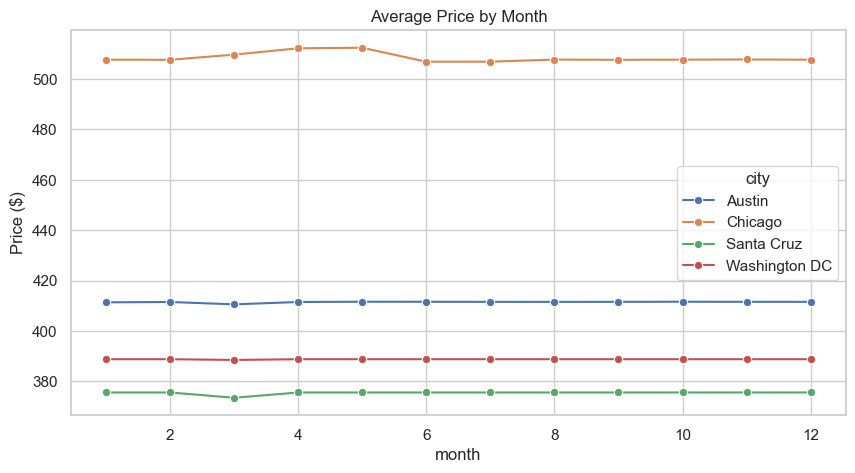

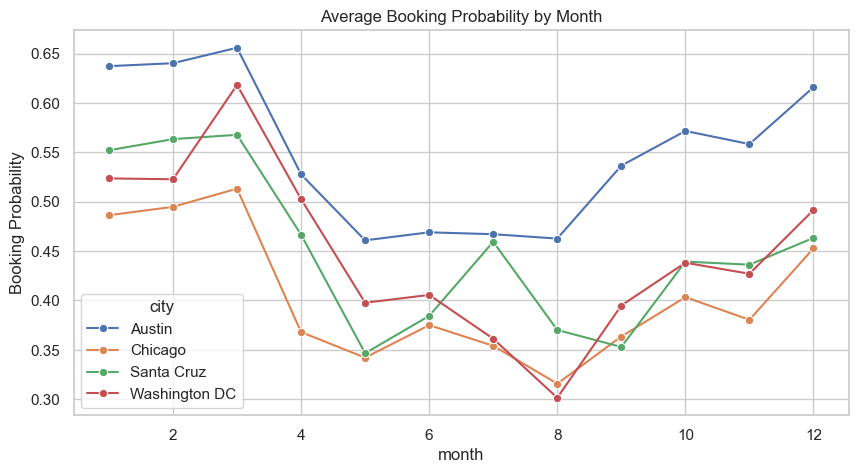

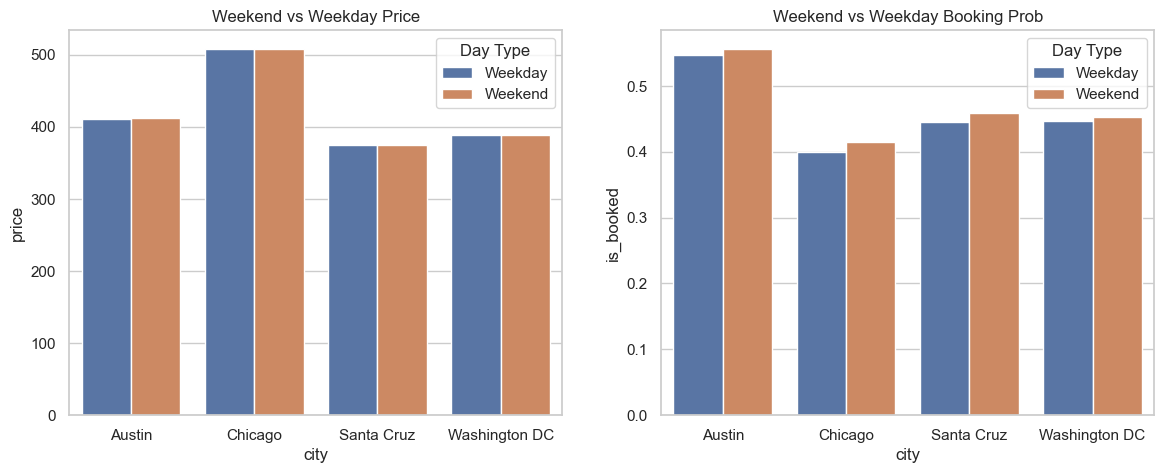

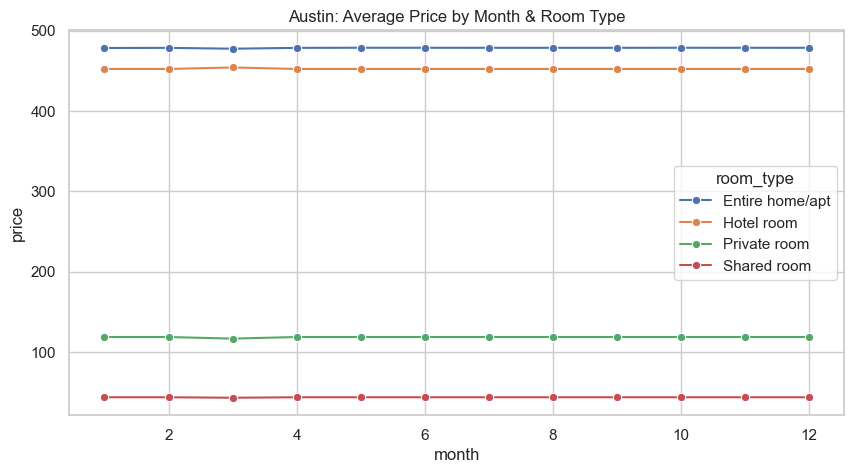

In [4]:
# 1. Average Price by Month
monthly_price = panel_df.groupby(['city', 'month'])['price'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_price, x='month', y='price', hue='city', marker='o')
plt.title('Average Price by Month')
plt.ylabel('Price ($)')
plt.show()

# 2. Average Booking Probability by Month
monthly_booking = panel_df.groupby(['city', 'month'])['is_booked'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_booking, x='month', y='is_booked', hue='city', marker='o')
plt.title('Average Booking Probability by Month')
plt.ylabel('Booking Probability')
plt.show()

# 3. Weekend vs Weekday
weekend_stats = panel_df.groupby(['city', 'is_weekend'])[['price', 'is_booked']].mean().reset_index()
weekend_stats['Day Type'] = weekend_stats['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=weekend_stats, x='city', y='price', hue='Day Type', ax=axes[0])
axes[0].set_title('Weekend vs Weekday Price')
sns.barplot(data=weekend_stats, x='city', y='is_booked', hue='Day Type', ax=axes[1])
axes[1].set_title('Weekend vs Weekday Booking Prob')
plt.show()

# 4. Price by Month & Room Type (using Austin as example to avoid clutter)
austin_df = panel_df[panel_df['city'] == 'Austin']
room_monthly = austin_df.groupby(['month', 'room_type'])['price'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=room_monthly, x='month', y='price', hue='room_type', marker='o')
plt.title('Austin: Average Price by Month & Room Type')
plt.show()

### Interpretation
Prices generally peak in the spring/summer months (around May) and dip in March. Weekend prices are consistently higher than weekdays across all cities, reflecting higher leisure demand.

## Part 3: Temporal Train/Validation/Test Split

We will split the data temporally:
- **Train**: Jan - Sep
- **Validation**: Oct - Nov
- **Test**: Dec - Feb

In [5]:
# Filter for specific months if dataset spans multiple years, but assuming 1 year snapshot for simplicity or using month number.
# The assignment implies a flow, let's assume the data covers a year forward.
# We'll use month numbers for simplicity as per instructions.

train_mask = panel_df['month'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9])
valid_mask = panel_df['month'].isin([10, 11])
test_mask = panel_df['month'].isin([12]) # Note: Assignment said Dec-Feb, but if data starts March 2025, Jan/Feb would be next year.
# Let's adjust based on the data date range.
print("Date Range:", panel_df['date'].min(), "to", panel_df['date'].max())

# Adjusting split based on actual 2025-2026 dates
# Train: March 2025 - Sept 2025
# Valid: Oct 2025 - Nov 2025
# Test: Dec 2025 - Feb 2026

train_df = panel_df[(panel_df['date'] >= '2025-03-01') & (panel_df['date'] < '2025-10-01')]
valid_df = panel_df[(panel_df['date'] >= '2025-10-01') & (panel_df['date'] < '2025-12-01')]
test_df = panel_df[(panel_df['date'] >= '2025-12-01')]

print(f"Train shape: {train_df.shape}")
print(f"Valid shape: {valid_df.shape}")
print(f"Test shape: {test_df.shape}")

# Prepare Features (X) and Targets (y)
features = ['month', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year', 
            'accommodates', 'bedrooms', 'beds', 'review_scores_rating']

# Encode categorical 'room_type' and 'city' if we want to use them
# Simple One-Hot Encoding
panel_encoded = pd.get_dummies(panel_df, columns=['room_type', 'city'], drop_first=True)

# Update feature list with new columns
new_features = [c for c in panel_encoded.columns if c not in panel_df.columns and c not in ['price', 'is_booked', 'date', 'listing_id', 'available', 'adjusted_price', 'neighbourhood_cleansed', 'host_is_superhost']]
features += new_features

# Re-split on encoded df
train_enc = panel_encoded.loc[train_df.index]
valid_enc = panel_encoded.loc[valid_df.index]
test_enc = panel_encoded.loc[test_df.index]

X_train = train_enc[features]
y_train_price = train_enc['price']
y_train_book = train_enc['is_booked']

X_valid = valid_enc[features]
y_valid_price = valid_enc['price']
y_valid_book = valid_enc['is_booked']

X_test = test_enc[features]
y_test_price = test_enc['price']
y_test_book = test_enc['is_booked']

print("Features used:", features)

Date Range: 2025-03-06 00:00:00 to 2026-03-31 00:00:00
Train shape: (1529764, 21)
Valid shape: (468480, 21)
Test shape: (805051, 21)


Features used: ['month', 'day_of_week', 'week_of_year', 'is_weekend', 'day_of_year', 'accommodates', 'bedrooms', 'beds', 'review_scores_rating', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'city_Chicago', 'city_Santa Cruz', 'city_Washington DC']


### 4.1 XGBoost Implementation

We start with XGBoost (Extreme Gradient Boosting), a powerful decision-tree-based ensemble method. We train two separate regressors/classifiers and evaluate them using RMSE/MAE for prices and Accuracy/ROC-AUC for bookings. 

XGBoost Price RMSE: 1384.38
XGBoost Price MAE: 372.92


XGBoost Booking AUC: 0.5896
XGBoost Booking Accuracy: 0.5736


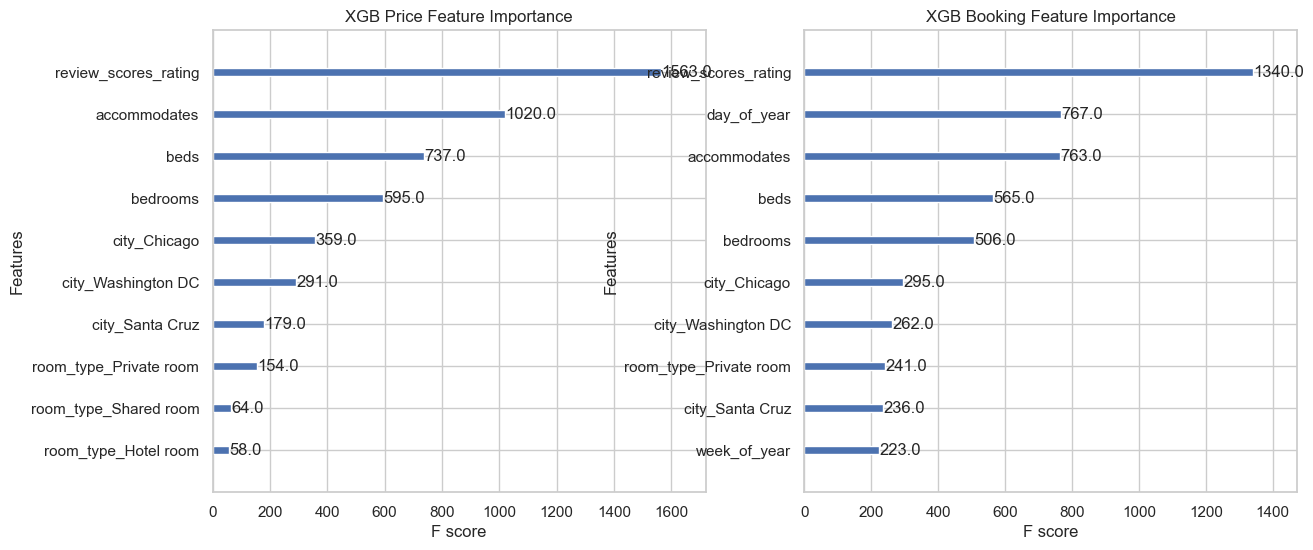

In [6]:
# --- XGBoost Regressor (Price) ---
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train, y_train_price, eval_set=[(X_valid, y_valid_price)], verbose=False)

pred_price = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test_price, pred_price))
mae = mean_absolute_error(y_test_price, pred_price)
print(f"XGBoost Price RMSE: {rmse:.2f}")
print(f"XGBoost Price MAE: {mae:.2f}")

# --- XGBoost Classifier (Booking) ---
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_clf.fit(X_train, y_train_book, eval_set=[(X_valid, y_valid_book)], verbose=False)

pred_book_prob = xgb_clf.predict_proba(X_test)[:, 1]
pred_book_class = xgb_clf.predict(X_test)
auc = roc_auc_score(y_test_book, pred_book_prob)
acc = accuracy_score(y_test_book, pred_book_class)
print(f"XGBoost Booking AUC: {auc:.4f}")
print(f"XGBoost Booking Accuracy: {acc:.4f}")

# --- Feature Importance ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
xgb.plot_importance(xgb_reg, max_num_features=10, ax=axes[0], title='XGB Price Feature Importance')
xgb.plot_importance(xgb_clf, max_num_features=10, ax=axes[1], title='XGB Booking Feature Importance')
plt.show()

### 4.2 Neural Network Models with TensorBoard

In [7]:
# Setup TensorBoard Logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Standardize Data for NN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# --- NN Regressor (Price) ---
model_reg = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Linear activation for regression
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training NN Regressor...")
history_reg = model_reg.fit(
    X_train_scaled, y_train_price,
    epochs=10,
    batch_size=256,
    validation_data=(X_valid_scaled, y_valid_price),
    callbacks=[tensorboard_callback],
    verbose=1
)

# --- NN Classifier (Booking) ---
model_clf = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Training NN Classifier...")
history_clf = model_clf.fit(
    X_train_scaled, y_train_book,
    epochs=10,
    batch_size=256,
    validation_data=(X_valid_scaled, y_valid_book),
    callbacks=[tensorboard_callback],
    verbose=1
)

Training NN Regressor...
Epoch 1/10


/Users/akshaymohanrevankar/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 48:03 483ms/step - loss: 1443071.5000 - mae: 328.6444


  89/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 576us/step - loss: 2663905.2500 - mae: 424.4885   


 193/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 526us/step - loss: 2661835.5000 - mae: 418.0445


 299/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 508us/step - loss: 2651274.5000 - mae: 405.3307


 401/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 504us/step - loss: 2633643.0000 - mae: 395.2232


 507/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 497us/step - loss: 2607235.5000 - mae: 389.1436


 613/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step - loss: 2588263.0000 - mae: 386.4575


 720/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 489us/step - loss: 2570516.2500 - mae: 385.3198


 828/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - loss: 2552407.5000 - mae: 384.7181


 935/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step - loss: 2539744.5000 - mae: 384.7614


1041/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - loss: 2530329.0000 - mae: 385.2390


1147/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - loss: 2520605.2500 - mae: 385.7249


1254/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - loss: 2511985.2500 - mae: 386.2787


1361/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - loss: 2504278.7500 - mae: 386.8849


1468/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - loss: 2498139.2500 - mae: 387.5558


1574/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - loss: 2493543.5000 - mae: 388.3146


1681/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - loss: 2489832.0000 - mae: 389.0974


1789/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - loss: 2486930.2500 - mae: 389.9235


1898/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - loss: 2483997.7500 - mae: 390.6949


2007/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 2481385.2500 - mae: 391.4412


2115/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - loss: 2478691.2500 - mae: 392.1150


2224/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - loss: 2476114.0000 - mae: 392.7392


2333/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step - loss: 2473483.0000 - mae: 393.3059


2443/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - loss: 2470458.7500 - mae: 393.8037


2552/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - loss: 2467460.0000 - mae: 394.2358


2661/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - loss: 2464520.2500 - mae: 394.6363


2769/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - loss: 2461831.7500 - mae: 395.0066


2878/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - loss: 2459208.5000 - mae: 395.3542


2987/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - loss: 2456695.7500 - mae: 395.6763


3096/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - loss: 2454186.5000 - mae: 395.9685


3205/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 2451766.0000 - mae: 396.2412


3313/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 2449456.5000 - mae: 396.5016


3421/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 2447033.2500 - mae: 396.7377


3529/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 2444395.7500 - mae: 396.9297


3638/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 2441853.2500 - mae: 397.1019


3747/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 2439518.0000 - mae: 397.2721


3857/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2437353.2500 - mae: 397.4433


3965/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2435462.5000 - mae: 397.6177


4074/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2433707.0000 - mae: 397.7996


4182/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2432013.2500 - mae: 397.9746


4291/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2430326.7500 - mae: 398.1443


4395/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2428813.0000 - mae: 398.3033


4503/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2427237.5000 - mae: 398.4583


4612/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2425779.2500 - mae: 398.6148


4721/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2424338.0000 - mae: 398.7648


4828/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2423041.2500 - mae: 398.9097


4934/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 2421853.2500 - mae: 399.0544


5043/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2420663.5000 - mae: 399.2009


5152/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2419551.2500 - mae: 399.3430


5260/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2418565.2500 - mae: 399.4839


5369/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2417630.0000 - mae: 399.6225


5478/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2416713.0000 - mae: 399.7536


5587/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2415737.7500 - mae: 399.8717


5695/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2414747.5000 - mae: 399.9768


5804/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 2413810.0000 - mae: 400.0790


5913/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 2412929.2500 - mae: 400.1809


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step - loss: 2412399.7500 - mae: 400.2380 - val_loss: 2300178.0000 - val_mae: 407.2457


Epoch 2/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:15 13ms/step - loss: 1517228.3750 - mae: 353.2845


 105/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - loss: 2806064.2500 - mae: 433.9626 


 213/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - loss: 2615830.2500 - mae: 426.0623


 322/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 470us/step - loss: 2508179.2500 - mae: 418.7956


 430/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2453676.5000 - mae: 414.5914


 538/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 2427480.2500 - mae: 412.2336


 647/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2417552.0000 - mae: 411.4180


 754/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2416108.7500 - mae: 411.3752


 862/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2413190.5000 - mae: 411.3417


 969/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2407963.5000 - mae: 411.0133


1078/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2402384.5000 - mae: 410.6196


1187/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2396569.2500 - mae: 410.1435


1293/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2392274.5000 - mae: 409.7881


1402/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2387291.2500 - mae: 409.3773


1511/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2383553.7500 - mae: 409.0391


1619/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2379637.0000 - mae: 408.6958


1728/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2376219.7500 - mae: 408.3824


1836/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2372879.2500 - mae: 408.0883


1944/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2370102.7500 - mae: 407.8337


2052/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2367883.0000 - mae: 407.6346


2160/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2366035.0000 - mae: 407.4804


2268/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2364313.2500 - mae: 407.3474


2378/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2362996.2500 - mae: 407.2367


2487/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2362128.0000 - mae: 407.1617


2596/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2361622.7500 - mae: 407.1256


2706/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2360981.5000 - mae: 407.0843


2816/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2360364.5000 - mae: 407.0494


2925/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2359801.0000 - mae: 407.0242


3034/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2359237.0000 - mae: 406.9919


3140/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2358595.0000 - mae: 406.9519


3248/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2357912.0000 - mae: 406.9091


3356/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2357224.2500 - mae: 406.8643


3466/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2356766.7500 - mae: 406.8367


3575/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 2356044.7500 - mae: 406.7881


3686/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 2355232.0000 - mae: 406.7249


3795/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 2354369.2500 - mae: 406.6542


3905/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2353538.5000 - mae: 406.5835


4013/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2352816.0000 - mae: 406.5197


4122/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2352188.2500 - mae: 406.4618


4230/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2351520.5000 - mae: 406.4014


4338/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2350884.7500 - mae: 406.3423


4447/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2350150.2500 - mae: 406.2762


4556/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2349341.0000 - mae: 406.2030


4664/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2348425.2500 - mae: 406.1205


4773/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2347542.0000 - mae: 406.0342


4883/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2346765.5000 - mae: 405.9556


4992/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2346051.7500 - mae: 405.8845


5102/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2345376.2500 - mae: 405.8156


5211/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2344772.7500 - mae: 405.7544


5320/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2344234.2500 - mae: 405.6992


5429/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2343805.0000 - mae: 405.6530


5539/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2343445.7500 - mae: 405.6142


5647/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2343167.7500 - mae: 405.5830


5756/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2342955.2500 - mae: 405.5585


5866/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2342695.0000 - mae: 405.5321


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2342385.2500 - mae: 405.5032


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - loss: 2342382.0000 - mae: 405.5029 - val_loss: 2263108.5000 - val_mae: 406.4473


Epoch 3/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:28 15ms/step - loss: 2942939.5000 - mae: 475.4267


 104/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - loss: 2158444.7500 - mae: 391.4392 


 212/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - loss: 2157811.0000 - mae: 389.4872


 317/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - loss: 2174535.0000 - mae: 390.2089


 422/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - loss: 2196720.7500 - mae: 391.6753


 531/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 473us/step - loss: 2210372.2500 - mae: 392.7747


 641/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - loss: 2223538.0000 - mae: 393.8534


 749/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 470us/step - loss: 2234954.5000 - mae: 394.8609


 857/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2241688.2500 - mae: 395.5549


 967/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2248241.7500 - mae: 396.2477


1076/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2255609.0000 - mae: 397.0387


1186/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2260165.7500 - mae: 397.7072


1296/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2262906.2500 - mae: 398.1931


1404/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2264843.5000 - mae: 398.5644


1511/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2266934.2500 - mae: 398.9126


1619/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2269099.7500 - mae: 399.2333


1723/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2270929.5000 - mae: 399.5282


1832/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2273509.2500 - mae: 399.8794


1941/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2276410.7500 - mae: 400.2535


2050/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2279166.5000 - mae: 400.6007


2159/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2282222.2500 - mae: 400.9506


2268/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2284990.7500 - mae: 401.2861


2378/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2287338.2500 - mae: 401.5985


2487/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2289198.2500 - mae: 401.8808


2594/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2290496.2500 - mae: 402.1113


2701/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2291268.5000 - mae: 402.2879


2810/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2291875.2500 - mae: 402.4390


2919/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2292363.5000 - mae: 402.5662


3028/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2292705.0000 - mae: 402.6826


3136/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2293015.0000 - mae: 402.7981


3246/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2293345.2500 - mae: 402.9280


3355/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2293605.7500 - mae: 403.0582


3464/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2293826.5000 - mae: 403.1830


3574/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2293898.0000 - mae: 403.2974


3682/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2294017.0000 - mae: 403.4093


3791/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2294246.5000 - mae: 403.5325


3900/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294389.0000 - mae: 403.6482


4007/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294466.5000 - mae: 403.7564


4113/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294571.7500 - mae: 403.8629


4221/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294660.7500 - mae: 403.9681


4330/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294750.0000 - mae: 404.0730


4439/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294864.7500 - mae: 404.1761


4548/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295006.0000 - mae: 404.2809


4657/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295222.5000 - mae: 404.3885


4763/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295424.2500 - mae: 404.4934


4869/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295578.0000 - mae: 404.5968


4977/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295636.2500 - mae: 404.6964


5086/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295770.2500 - mae: 404.8009


5194/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295801.2500 - mae: 404.8936


5302/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295775.7500 - mae: 404.9803


5411/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295688.0000 - mae: 405.0611


5520/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295510.2500 - mae: 405.1317


5629/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295319.5000 - mae: 405.1962


5737/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2295169.5000 - mae: 405.2625


5844/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294947.2500 - mae: 405.3219


5954/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2294646.0000 - mae: 405.3749


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 543us/step - loss: 2294585.2500 - mae: 405.3855 - val_loss: 2198754.0000 - val_mae: 412.9315


Epoch 4/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:17 13ms/step - loss: 5662740.0000 - mae: 662.5729


 105/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step - loss: 2303811.2500 - mae: 429.0767 


 213/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - loss: 2244425.7500 - mae: 418.3459


 321/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - loss: 2269509.7500 - mae: 418.2527


 428/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 470us/step - loss: 2284908.2500 - mae: 419.0460


 537/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 2288362.7500 - mae: 418.7501


 647/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2289918.7500 - mae: 418.6263


 756/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2291101.7500 - mae: 418.5484


 863/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2289932.0000 - mae: 418.2532


 970/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2286962.5000 - mae: 417.8006


1076/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2285334.5000 - mae: 417.4371


1184/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2284201.0000 - mae: 417.1432


1291/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2283009.0000 - mae: 416.8713


1399/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2281460.7500 - mae: 416.6189


1508/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2280506.5000 - mae: 416.4489


1615/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2279499.0000 - mae: 416.3135


1723/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2278304.5000 - mae: 416.1735


1832/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2277058.2500 - mae: 416.0258


1940/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2275632.0000 - mae: 415.8620


2049/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2274037.0000 - mae: 415.6615


2157/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2272361.2500 - mae: 415.4521


2266/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2270978.5000 - mae: 415.2700


2375/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2269702.5000 - mae: 415.0974


2483/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2268420.5000 - mae: 414.9315


2591/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2266815.2500 - mae: 414.7454


2700/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2264977.2500 - mae: 414.5386


2809/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2263072.7500 - mae: 414.3246


2918/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2261332.5000 - mae: 414.1216


3027/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2259749.5000 - mae: 413.9316


3134/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2258477.0000 - mae: 413.7695


3242/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2257274.2500 - mae: 413.6180


3350/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2256190.0000 - mae: 413.4789


3458/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2255247.2500 - mae: 413.3539


3567/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2254270.0000 - mae: 413.2279


3672/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2253315.5000 - mae: 413.1057


3778/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2252471.5000 - mae: 412.9904


3887/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2251675.2500 - mae: 412.8811


3995/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2251045.0000 - mae: 412.7875


4104/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2250477.7500 - mae: 412.7026


4213/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2249782.7500 - mae: 412.6087


4322/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2249081.5000 - mae: 412.5151


4431/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2248474.7500 - mae: 412.4301


4540/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2247838.5000 - mae: 412.3493


4648/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2247211.2500 - mae: 412.2680


4756/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2246691.7500 - mae: 412.1970


4864/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2246212.2500 - mae: 412.1312


4972/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2245755.0000 - mae: 412.0674


5080/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2245322.5000 - mae: 412.0067


5189/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2244930.5000 - mae: 411.9499


5296/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2244599.5000 - mae: 411.8983


5404/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2244251.5000 - mae: 411.8463


5513/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2243938.7500 - mae: 411.7949


5621/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2243631.0000 - mae: 411.7445


5730/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2243324.7500 - mae: 411.6966


5839/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2242962.0000 - mae: 411.6454


5947/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2242609.5000 - mae: 411.5963


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step - loss: 2242511.2500 - mae: 411.5826 - val_loss: 2144542.2500 - val_mae: 391.1389


Epoch 5/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:15 13ms/step - loss: 1656109.2500 - mae: 369.6945


 108/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - loss: 2555306.5000 - mae: 431.0601 


 214/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 472us/step - loss: 2479290.7500 - mae: 429.5581


 321/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - loss: 2436568.2500 - mae: 427.2403


 430/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2400719.0000 - mae: 424.6585


 539/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2380162.2500 - mae: 423.1241


 645/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 2358866.7500 - mae: 421.5219


 754/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2341415.2500 - mae: 420.0981


 864/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2322774.2500 - mae: 418.5798


 973/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2307327.5000 - mae: 417.2769


1082/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2293941.7500 - mae: 416.0550


1192/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2282883.0000 - mae: 415.0123


1301/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2272146.7500 - mae: 413.9796


1409/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2262926.2500 - mae: 413.0636


1518/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2254928.2500 - mae: 412.2388


1628/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2247583.2500 - mae: 411.4823


1737/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 2241316.2500 - mae: 410.8329


1847/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 2236914.0000 - mae: 410.3563


1958/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2233150.5000 - mae: 409.9450


2068/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2229763.2500 - mae: 409.5745


2177/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2226592.7500 - mae: 409.2350


2285/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2223422.0000 - mae: 408.8970


2394/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2220883.0000 - mae: 408.6043


2504/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2218784.5000 - mae: 408.3439


2613/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2217140.5000 - mae: 408.1231


2722/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2215664.5000 - mae: 407.9294


2831/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2214333.2500 - mae: 407.7509


2940/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2213158.0000 - mae: 407.5844


3051/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2212217.0000 - mae: 407.4383


3161/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2211434.5000 - mae: 407.3073


3270/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2210887.5000 - mae: 407.1993


3380/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2210248.5000 - mae: 407.0883


3486/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2209576.5000 - mae: 406.9774


3595/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2208817.5000 - mae: 406.8567


3705/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2208002.5000 - mae: 406.7296


3814/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2207035.5000 - mae: 406.5907


3924/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2206049.2500 - mae: 406.4471


4033/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2205149.2500 - mae: 406.3108


4142/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2204275.2500 - mae: 406.1797


4252/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2203455.5000 - mae: 406.0531


4362/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2202798.0000 - mae: 405.9428


4473/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2202198.2500 - mae: 405.8421


4583/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2201534.2500 - mae: 405.7415


4694/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2200892.2500 - mae: 405.6439


4802/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2200339.7500 - mae: 405.5549


4911/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2199850.7500 - mae: 405.4735


5020/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2199441.2500 - mae: 405.4003


5129/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2199080.5000 - mae: 405.3310


5238/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2198697.2500 - mae: 405.2604


5348/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2198304.0000 - mae: 405.1916


5453/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2197932.2500 - mae: 405.1288


5563/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2197615.0000 - mae: 405.0730


5672/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2197238.2500 - mae: 405.0161


5781/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2196828.0000 - mae: 404.9552


5891/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2196410.0000 - mae: 404.8942


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 540us/step - loss: 2196115.0000 - mae: 404.8502 - val_loss: 2108770.7500 - val_mae: 406.6188


Epoch 6/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:15 13ms/step - loss: 1094876.3750 - mae: 299.5710


 105/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - loss: 2378969.2500 - mae: 427.0218 


 213/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - loss: 2306736.0000 - mae: 418.2985


 322/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2255302.2500 - mae: 412.6201


 431/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2222744.7500 - mae: 408.8539


 539/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2204642.7500 - mae: 406.6170


 648/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2192585.7500 - mae: 405.2317


 757/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2187566.2500 - mae: 404.3700


 866/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2186217.0000 - mae: 403.9485


 975/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2184997.2500 - mae: 403.6810


1084/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2185739.5000 - mae: 403.5506


1194/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2184834.7500 - mae: 403.3403


1303/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2183952.2500 - mae: 403.1500


1413/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2182989.7500 - mae: 402.9376


1522/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2182049.2500 - mae: 402.7225


1631/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2180570.2500 - mae: 402.4639


1739/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2179262.5000 - mae: 402.2277


1847/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step - loss: 2177934.5000 - mae: 401.9851


1956/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2176088.2500 - mae: 401.7060


2066/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2174406.2500 - mae: 401.4326


2175/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2173336.5000 - mae: 401.2011


2285/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2172281.7500 - mae: 400.9823


2394/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2171243.5000 - mae: 400.7641


2503/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2170155.2500 - mae: 400.5467


2611/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2168887.0000 - mae: 400.3363


2721/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2167701.2500 - mae: 400.1424


2829/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2166796.0000 - mae: 399.9849


2938/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2165893.2500 - mae: 399.8423


3048/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2165051.7500 - mae: 399.7191


3157/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2164253.5000 - mae: 399.6026


3266/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2163580.7500 - mae: 399.4961


3375/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2162966.0000 - mae: 399.4025


3484/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2162316.7500 - mae: 399.3168


3588/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2161617.2500 - mae: 399.2332


3694/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2160943.2500 - mae: 399.1476


3803/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - loss: 2160302.2500 - mae: 399.0600


3912/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2159783.0000 - mae: 398.9832


4021/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 2159365.7500 - mae: 398.9220


4128/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2159021.7500 - mae: 398.8695


4236/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2158781.0000 - mae: 398.8299


4343/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2158588.0000 - mae: 398.7979


4450/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2158347.0000 - mae: 398.7616


4558/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2158075.0000 - mae: 398.7224


4665/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2157852.2500 - mae: 398.6883


4774/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2157649.2500 - mae: 398.6571


4882/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2157413.0000 - mae: 398.6267


4990/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2157188.0000 - mae: 398.5976


5098/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2157020.0000 - mae: 398.5731


5208/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2156804.5000 - mae: 398.5459


5316/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2156612.7500 - mae: 398.5200


5424/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2156520.0000 - mae: 398.5016


5532/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2156459.7500 - mae: 398.4875


5641/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2156339.5000 - mae: 398.4705


5748/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2156149.7500 - mae: 398.4463


5856/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2155984.7500 - mae: 398.4229


5964/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 2155825.5000 - mae: 398.3991


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 543us/step - loss: 2155803.5000 - mae: 398.3961 - val_loss: 2086910.3750 - val_mae: 374.2484


Epoch 7/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:16 13ms/step - loss: 2079693.0000 - mae: 422.7179


 106/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - loss: 1970638.0000 - mae: 383.2092 


 213/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - loss: 2064760.6250 - mae: 390.0312


 320/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 472us/step - loss: 2066507.7500 - mae: 390.5773


 427/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - loss: 2059043.8750 - mae: 390.2881


 535/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 470us/step - loss: 2062353.1250 - mae: 390.1854


 643/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2074714.7500 - mae: 390.9673


 750/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2084984.0000 - mae: 391.8572


 858/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2094188.3750 - mae: 392.6826


 966/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2101715.2500 - mae: 393.2755


1075/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 2107588.0000 - mae: 393.7311


1184/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 2112758.2500 - mae: 394.0981


1293/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2116215.0000 - mae: 394.3616


1401/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2117292.2500 - mae: 394.4248


1510/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2117485.0000 - mae: 394.4065


1616/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2118141.0000 - mae: 394.4000


1724/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2119143.7500 - mae: 394.4013


1831/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2120018.0000 - mae: 394.4099


1939/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2120667.7500 - mae: 394.4132


2048/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2120998.2500 - mae: 394.3835


2156/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2121427.7500 - mae: 394.3471


2264/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2121785.5000 - mae: 394.3092


2372/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2121925.5000 - mae: 394.2494


2480/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 467us/step - loss: 2122199.7500 - mae: 394.1948


2589/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2122657.7500 - mae: 394.1518


2697/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2122895.5000 - mae: 394.0910


2805/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2123049.7500 - mae: 394.0302


2914/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2123429.5000 - mae: 393.9937


3023/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2123975.5000 - mae: 393.9878


3131/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2124627.5000 - mae: 393.9998


3241/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2125246.2500 - mae: 394.0164


3350/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2125566.7500 - mae: 394.0194


3458/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2125777.0000 - mae: 394.0215


3561/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2125948.0000 - mae: 394.0182


3669/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2126232.5000 - mae: 394.0251


3777/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2126538.7500 - mae: 394.0383


3885/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2126784.5000 - mae: 394.0507


3993/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2127070.2500 - mae: 394.0725


4102/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2127329.2500 - mae: 394.0930


4212/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2127718.2500 - mae: 394.1203


4321/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128104.0000 - mae: 394.1520


4429/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128411.2500 - mae: 394.1823


4536/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128605.5000 - mae: 394.2000


4644/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128697.7500 - mae: 394.2073


4751/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128754.5000 - mae: 394.2102


4859/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128775.5000 - mae: 394.2056


4968/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128821.0000 - mae: 394.2007


5076/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128759.5000 - mae: 394.1869


5184/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2128636.0000 - mae: 394.1686


5294/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128520.0000 - mae: 394.1503


5402/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128405.2500 - mae: 394.1348


5510/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128332.5000 - mae: 394.1225


5619/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128281.0000 - mae: 394.1105


5728/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128238.7500 - mae: 394.0986


5837/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128196.5000 - mae: 394.0870


5945/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2128142.0000 - mae: 394.0741


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step - loss: 2128124.0000 - mae: 394.0701 - val_loss: 2071398.0000 - val_mae: 393.5548


Epoch 8/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:16 13ms/step - loss: 2713702.0000 - mae: 412.9247


 106/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - loss: 2107120.7500 - mae: 392.7112 


 215/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - loss: 2051901.7500 - mae: 388.3289


 324/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 2062079.6250 - mae: 388.0580


 433/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2065893.2500 - mae: 387.8378


 542/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2062595.1250 - mae: 387.4868


 653/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2059294.0000 - mae: 387.2018


 761/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - loss: 2058597.8750 - mae: 387.0798


 871/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2059039.0000 - mae: 387.1384


 981/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2059275.1250 - mae: 387.2780


1089/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2060756.1250 - mae: 387.4807


1198/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2063796.6250 - mae: 387.7956


1306/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2067520.2500 - mae: 388.2094


1415/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2070759.3750 - mae: 388.5969


1524/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2073760.7500 - mae: 388.9517


1634/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 462us/step - loss: 2076515.8750 - mae: 389.2721


1744/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2079199.8750 - mae: 389.5589


1854/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2081507.3750 - mae: 389.7982


1963/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2084090.2500 - mae: 390.0464


2073/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2087057.1250 - mae: 390.3374


2182/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2089650.3750 - mae: 390.6082


2291/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2092178.5000 - mae: 390.8634


2399/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2094617.7500 - mae: 391.0949


2508/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2096593.7500 - mae: 391.2974


2617/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2098261.0000 - mae: 391.4662


2727/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2099708.7500 - mae: 391.6259


2836/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2101122.2500 - mae: 391.7753


2946/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2102453.2500 - mae: 391.9038


3056/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2103829.2500 - mae: 392.0236


3165/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2105238.0000 - mae: 392.1520


3273/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2106356.5000 - mae: 392.2605


3382/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2107206.5000 - mae: 392.3413


3490/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2107906.0000 - mae: 392.4004


3596/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2108450.0000 - mae: 392.4451


3705/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step - loss: 2109037.0000 - mae: 392.4901


3814/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2109467.0000 - mae: 392.5177


3923/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2109934.0000 - mae: 392.5452


4033/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2110394.0000 - mae: 392.5718


4143/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2110777.5000 - mae: 392.5960


4253/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2111107.5000 - mae: 392.6160


4362/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2111445.7500 - mae: 392.6358


4472/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2111784.5000 - mae: 392.6581


4582/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112016.7500 - mae: 392.6738


4689/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112192.0000 - mae: 392.6829


4798/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112320.0000 - mae: 392.6875


4908/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112399.5000 - mae: 392.6893


5017/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112485.2500 - mae: 392.6914


5126/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112542.5000 - mae: 392.6899


5235/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112593.0000 - mae: 392.6864


5344/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112596.5000 - mae: 392.6803


5453/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112573.2500 - mae: 392.6700


5561/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112559.2500 - mae: 392.6606


5669/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112512.0000 - mae: 392.6485


5779/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112471.7500 - mae: 392.6352


5890/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 2112457.0000 - mae: 392.6232


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 540us/step - loss: 2112425.7500 - mae: 392.6125 - val_loss: 2061662.0000 - val_mae: 390.4237


Epoch 9/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:15 13ms/step - loss: 2037025.7500 - mae: 359.7267


 107/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 472us/step - loss: 2351703.0000 - mae: 407.4673 


 215/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 2346408.2500 - mae: 409.7306


 324/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2319188.7500 - mae: 409.2323


 432/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2308046.7500 - mae: 409.0602


 541/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2291062.5000 - mae: 408.1793


 649/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2276813.0000 - mae: 407.2885


 755/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2266393.7500 - mae: 406.5834


 864/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2257803.2500 - mae: 405.8941


 973/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2250979.7500 - mae: 405.3391


1082/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2244172.7500 - mae: 404.8099


1191/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2238340.7500 - mae: 404.3419


1299/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2232683.7500 - mae: 403.8676


1406/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - loss: 2227489.0000 - mae: 403.3842


1513/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2222503.0000 - mae: 402.9258


1621/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2217981.7500 - mae: 402.5065


1730/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2214126.0000 - mae: 402.1413


1839/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2210067.5000 - mae: 401.7761


1948/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2205984.0000 - mae: 401.4018


2057/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2202174.0000 - mae: 401.0465


2165/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2198724.2500 - mae: 400.7062


2274/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2195575.7500 - mae: 400.3902


2383/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2192315.2500 - mae: 400.0701


2489/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2189425.0000 - mae: 399.7822


2596/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2186642.2500 - mae: 399.5072


2702/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2184179.0000 - mae: 399.2462


2807/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2182039.5000 - mae: 399.0158


2914/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2180236.2500 - mae: 398.8211


3022/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2178803.5000 - mae: 398.6614


3129/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2177447.0000 - mae: 398.5190


3236/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2176125.7500 - mae: 398.3824


3344/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2174648.5000 - mae: 398.2390


3451/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2173184.5000 - mae: 398.0924


3556/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2171747.5000 - mae: 397.9429


3664/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2170408.2500 - mae: 397.7936


3772/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - loss: 2169077.2500 - mae: 397.6445


3881/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2167699.5000 - mae: 397.4872


3989/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2166283.5000 - mae: 397.3249


4098/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2164886.2500 - mae: 397.1615


4205/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2163621.2500 - mae: 397.0113


4314/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2162304.7500 - mae: 396.8594


4422/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2161065.2500 - mae: 396.7140


4529/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2159824.7500 - mae: 396.5714


4637/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2158586.5000 - mae: 396.4326


4745/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2157309.0000 - mae: 396.2934


4851/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2156156.0000 - mae: 396.1619


4959/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2155089.0000 - mae: 396.0377


5068/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2154034.7500 - mae: 395.9212


5176/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2153026.5000 - mae: 395.8120


5284/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2152089.2500 - mae: 395.7094


5394/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 2151185.0000 - mae: 395.6111


5503/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2150296.0000 - mae: 395.5153


5612/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2149457.0000 - mae: 395.4243


5720/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2148677.7500 - mae: 395.3416


5829/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2147858.2500 - mae: 395.2563


5938/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2147054.0000 - mae: 395.1708


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step - loss: 2146764.5000 - mae: 395.1400 - val_loss: 2051364.3750 - val_mae: 384.6642


Epoch 10/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:19 13ms/step - loss: 844801.5000 - mae: 362.0353


 107/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - loss: 1882231.8750 - mae: 375.1462


 214/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 473us/step - loss: 1930073.2500 - mae: 375.0032


 322/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 470us/step - loss: 1950465.7500 - mae: 375.1394


 431/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 468us/step - loss: 1972307.7500 - mae: 375.9972


 539/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 1986222.8750 - mae: 376.8077


 647/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - loss: 1997431.6250 - mae: 377.5757


 755/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2007027.5000 - mae: 378.2941


 863/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2012546.1250 - mae: 378.7530


 971/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 2017520.3750 - mae: 379.0984


1079/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2020365.1250 - mae: 379.3598


1187/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2023979.6250 - mae: 379.6927


1296/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2027482.7500 - mae: 380.0620


1404/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2030709.1250 - mae: 380.4011


1513/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2034430.8750 - mae: 380.7968


1622/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 465us/step - loss: 2038775.3750 - mae: 381.2482


1731/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2042642.2500 - mae: 381.6758


1840/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2046141.3750 - mae: 382.0907


1949/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2049077.1250 - mae: 382.4614


2058/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2051463.7500 - mae: 382.7789


2166/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2053728.5000 - mae: 383.0599


2271/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2055816.0000 - mae: 383.3211


2379/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2057507.8750 - mae: 383.5519


2489/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2058961.0000 - mae: 383.7461


2598/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2060431.3750 - mae: 383.9292


2707/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2061820.7500 - mae: 384.1025


2815/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2063132.8750 - mae: 384.2694


2924/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2064339.3750 - mae: 384.4313


3033/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2065715.3750 - mae: 384.6101


3137/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2066839.1250 - mae: 384.7697


3244/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2067983.2500 - mae: 384.9296


3353/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2069104.3750 - mae: 385.0801


3462/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step - loss: 2070068.3750 - mae: 385.2127


3571/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2070931.6250 - mae: 385.3320


3679/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2071828.1250 - mae: 385.4546


3787/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 2072681.8750 - mae: 385.5697


3896/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2073489.8750 - mae: 385.6803


4004/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2074121.7500 - mae: 385.7763


4111/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2074686.6250 - mae: 385.8630


4218/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2075228.0000 - mae: 385.9428


4326/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2075707.8750 - mae: 386.0164


4435/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2076214.7500 - mae: 386.0903


4544/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2076711.0000 - mae: 386.1624


4652/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2077114.1250 - mae: 386.2234


4761/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2077459.6250 - mae: 386.2755


4869/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2077844.7500 - mae: 386.3290


4978/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2078209.1250 - mae: 386.3836


5088/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2078590.7500 - mae: 386.4385


5197/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2078922.1250 - mae: 386.4893


5300/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 2079208.0000 - mae: 386.5343


5409/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2079501.8750 - mae: 386.5786


5518/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2079783.3750 - mae: 386.6202


5627/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2079974.7500 - mae: 386.6556


5735/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2080172.1250 - mae: 386.6895


5844/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2080399.2500 - mae: 386.7255


5952/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 2080658.0000 - mae: 386.7636


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step - loss: 2080722.2500 - mae: 386.7729 - val_loss: 2044727.8750 - val_mae: 383.2789


Training NN Classifier...
Epoch 1/10


/Users/akshaymohanrevankar/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 46:47 470ms/step - accuracy: 0.4336 - loss: 0.7968


  85/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 597us/step - accuracy: 0.5390 - loss: 0.7016   


 189/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 533us/step - accuracy: 0.5631 - loss: 0.6879


 294/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 513us/step - accuracy: 0.5752 - loss: 0.6814


 400/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 502us/step - accuracy: 0.5831 - loss: 0.6771


 506/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 496us/step - accuracy: 0.5888 - loss: 0.6741


 612/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step - accuracy: 0.5930 - loss: 0.6717


 718/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 490us/step - accuracy: 0.5964 - loss: 0.6698


 824/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 488us/step - accuracy: 0.5993 - loss: 0.6681


 930/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - accuracy: 0.6019 - loss: 0.6665


1035/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - accuracy: 0.6040 - loss: 0.6651


1141/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 485us/step - accuracy: 0.6060 - loss: 0.6639


1248/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.6077 - loss: 0.6628


1353/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.6092 - loss: 0.6618


1460/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6106 - loss: 0.6609


1568/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6118 - loss: 0.6601


1674/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6130 - loss: 0.6593


1780/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6140 - loss: 0.6586


1884/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.6150 - loss: 0.6579


1989/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.6159 - loss: 0.6573


2094/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 480us/step - accuracy: 0.6167 - loss: 0.6566


2201/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.6175 - loss: 0.6561


2308/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.6182 - loss: 0.6555


2415/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.6189 - loss: 0.6550


2521/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6196 - loss: 0.6545


2627/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6202 - loss: 0.6540


2732/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6208 - loss: 0.6536


2838/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6213 - loss: 0.6532


2946/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6219 - loss: 0.6527


3053/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6224 - loss: 0.6523


3160/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6229 - loss: 0.6520


3265/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6233 - loss: 0.6516


3372/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6238 - loss: 0.6512


3479/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6242 - loss: 0.6509


3585/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6246 - loss: 0.6506


3691/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6250 - loss: 0.6503


3797/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6254 - loss: 0.6500


3903/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6258 - loss: 0.6497


4009/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6261 - loss: 0.6494


4116/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6265 - loss: 0.6491


4223/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6268 - loss: 0.6489


4329/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6271 - loss: 0.6486


4435/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6274 - loss: 0.6484


4541/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6277 - loss: 0.6481


4647/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6280 - loss: 0.6479


4753/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6283 - loss: 0.6476


4858/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6286 - loss: 0.6474


4964/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6288 - loss: 0.6472


5070/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6291 - loss: 0.6470


5177/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6293 - loss: 0.6468


5284/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6296 - loss: 0.6466


5391/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6298 - loss: 0.6464


5497/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6301 - loss: 0.6462


5603/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6303 - loss: 0.6460


5708/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6305 - loss: 0.6458


5812/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6307 - loss: 0.6456


5917/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6309 - loss: 0.6454


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 4s 570us/step - accuracy: 0.6311 - loss: 0.6453 - val_accuracy: 0.6205 - val_loss: 0.6520


Epoch 2/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:08 12ms/step - accuracy: 0.6602 - loss: 0.6178


 104/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - accuracy: 0.6470 - loss: 0.6287 


 209/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6483 - loss: 0.6275


 315/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6495 - loss: 0.6265


 420/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6502 - loss: 0.6261


 526/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6506 - loss: 0.6259


 632/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6508 - loss: 0.6259


 738/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6509 - loss: 0.6258


 844/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6511 - loss: 0.6258


 950/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6511 - loss: 0.6258


1056/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6511 - loss: 0.6258


1160/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6511 - loss: 0.6258


1262/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6511 - loss: 0.6258


1367/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6511 - loss: 0.6258


1473/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6511 - loss: 0.6259


1579/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6511 - loss: 0.6258


1684/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6511 - loss: 0.6258


1789/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6511 - loss: 0.6258


1893/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


1998/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


2104/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


2208/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


2314/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


2420/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


2525/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6511 - loss: 0.6258


2631/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6512 - loss: 0.6257


2736/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6512 - loss: 0.6257


2842/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6512 - loss: 0.6257


2948/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6512 - loss: 0.6257


3054/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6512 - loss: 0.6257


3160/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6513 - loss: 0.6256


3266/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6513 - loss: 0.6256


3373/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6513 - loss: 0.6256


3479/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6514 - loss: 0.6256


3585/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6514 - loss: 0.6255


3691/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6514 - loss: 0.6255


3797/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6514 - loss: 0.6255


3902/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6515 - loss: 0.6255


4008/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6515 - loss: 0.6254


4114/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6515 - loss: 0.6254


4220/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6515 - loss: 0.6254


4324/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6516 - loss: 0.6254


4429/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6516 - loss: 0.6253


4535/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6516 - loss: 0.6253


4642/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6516 - loss: 0.6253


4747/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6517 - loss: 0.6252


4853/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6517 - loss: 0.6252


4960/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6517 - loss: 0.6252


5065/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6517 - loss: 0.6252


5171/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6517 - loss: 0.6251


5278/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6518 - loss: 0.6251


5384/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6518 - loss: 0.6251


5490/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6518 - loss: 0.6251


5597/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6518 - loss: 0.6250


5702/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6519 - loss: 0.6250


5808/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6519 - loss: 0.6250


5914/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6519 - loss: 0.6249


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 558us/step - accuracy: 0.6519 - loss: 0.6249 - val_accuracy: 0.6232 - val_loss: 0.6426


Epoch 3/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:08 12ms/step - accuracy: 0.6641 - loss: 0.6257


 104/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 488us/step - accuracy: 0.6596 - loss: 0.6149 


 210/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6584 - loss: 0.6163


 314/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6579 - loss: 0.6172


 419/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6575 - loss: 0.6179


 524/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6570 - loss: 0.6186


 630/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6568 - loss: 0.6189


 736/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6567 - loss: 0.6191


 842/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6567 - loss: 0.6193


 949/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6566 - loss: 0.6194


1051/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6565 - loss: 0.6195


1155/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6565 - loss: 0.6195


1259/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6565 - loss: 0.6196


1364/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6565 - loss: 0.6196


1468/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6565 - loss: 0.6196


1574/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6565 - loss: 0.6196


1680/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6566 - loss: 0.6196


1786/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6566 - loss: 0.6196


1893/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6566 - loss: 0.6196


2000/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6566 - loss: 0.6196


2108/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6566 - loss: 0.6196


2216/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6566 - loss: 0.6196


2321/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6567 - loss: 0.6196


2426/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6567 - loss: 0.6195


2532/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6567 - loss: 0.6195


2639/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6568 - loss: 0.6195


2746/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6568 - loss: 0.6195


2853/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6568 - loss: 0.6194


2961/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6569 - loss: 0.6194


3068/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6569 - loss: 0.6194


3174/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6569 - loss: 0.6194


3280/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6569 - loss: 0.6193


3386/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6570 - loss: 0.6193


3493/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6570 - loss: 0.6193


3599/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6570 - loss: 0.6193


3705/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6571 - loss: 0.6192


3812/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6571 - loss: 0.6192


3919/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6571 - loss: 0.6192


4026/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6571 - loss: 0.6192


4133/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6572 - loss: 0.6192


4241/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6572 - loss: 0.6191


4348/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6572 - loss: 0.6191


4455/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6572 - loss: 0.6191


4562/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6572 - loss: 0.6191


4669/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6572 - loss: 0.6191


4776/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6573 - loss: 0.6190


4884/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6573 - loss: 0.6190


4990/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6573 - loss: 0.6190


5098/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6573 - loss: 0.6190


5205/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6573 - loss: 0.6190


5311/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6573 - loss: 0.6190


5417/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6573 - loss: 0.6189


5524/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6574 - loss: 0.6189


5631/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6574 - loss: 0.6189


5738/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6574 - loss: 0.6189


5845/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6574 - loss: 0.6189


5951/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6574 - loss: 0.6188


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 554us/step - accuracy: 0.6574 - loss: 0.6188 - val_accuracy: 0.6249 - val_loss: 0.6399


Epoch 4/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:13 12ms/step - accuracy: 0.6133 - loss: 0.6571


 104/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - accuracy: 0.6562 - loss: 0.6184 


 210/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6575 - loss: 0.6177


 316/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6580 - loss: 0.6174


 419/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6581 - loss: 0.6173


 524/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6582 - loss: 0.6172


 625/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6583 - loss: 0.6171


 730/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6583 - loss: 0.6171


 835/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6583 - loss: 0.6170


 941/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6583 - loss: 0.6171


1047/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6583 - loss: 0.6170


1153/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6584 - loss: 0.6170


1260/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6584 - loss: 0.6169


1366/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6585 - loss: 0.6168


1473/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6586 - loss: 0.6168


1579/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6586 - loss: 0.6167


1686/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6587 - loss: 0.6166


1793/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6588 - loss: 0.6165


1899/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6588 - loss: 0.6165


2005/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6589 - loss: 0.6164


2111/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6589 - loss: 0.6164


2217/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6590 - loss: 0.6163


2322/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6590 - loss: 0.6163


2429/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6591 - loss: 0.6162


2534/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6591 - loss: 0.6162


2640/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6592 - loss: 0.6161


2746/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6592 - loss: 0.6161


2852/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6593 - loss: 0.6160


2959/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6593 - loss: 0.6160


3065/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6593 - loss: 0.6160


3171/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6594 - loss: 0.6159


3278/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6594 - loss: 0.6159


3385/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6594 - loss: 0.6159


3492/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6595 - loss: 0.6159


3597/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6595 - loss: 0.6158


3703/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6595 - loss: 0.6158


3809/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6595 - loss: 0.6158


3916/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6595 - loss: 0.6158


4020/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6596 - loss: 0.6157


4125/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6596 - loss: 0.6157


4230/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6596 - loss: 0.6157


4336/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6596 - loss: 0.6157


4441/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6597 - loss: 0.6157


4546/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6597 - loss: 0.6156


4650/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6597 - loss: 0.6156


4755/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6597 - loss: 0.6156


4861/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6598 - loss: 0.6156


4968/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6598 - loss: 0.6155


5074/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6598 - loss: 0.6155


5180/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6598 - loss: 0.6155


5286/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6598 - loss: 0.6155


5392/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6599 - loss: 0.6154


5497/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6599 - loss: 0.6154


5602/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6599 - loss: 0.6154


5708/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6599 - loss: 0.6154


5813/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6600 - loss: 0.6153


5919/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6600 - loss: 0.6153


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 557us/step - accuracy: 0.6600 - loss: 0.6153 - val_accuracy: 0.6188 - val_loss: 0.6384


Epoch 5/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:10 12ms/step - accuracy: 0.5938 - loss: 0.6867


 105/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.6619 - loss: 0.6109 


 211/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6626 - loss: 0.6102


 318/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6630 - loss: 0.6099


 421/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6627 - loss: 0.6101


 524/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6626 - loss: 0.6102


 629/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6626 - loss: 0.6104


 735/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6625 - loss: 0.6105


 841/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6624 - loss: 0.6106


 947/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6623 - loss: 0.6107


1053/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6623 - loss: 0.6108


1159/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6622 - loss: 0.6109


1265/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6622 - loss: 0.6110


1371/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6622 - loss: 0.6111


1477/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6622 - loss: 0.6112


1583/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6622 - loss: 0.6112


1688/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6622 - loss: 0.6112


1793/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6113


1898/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6113


2003/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6113


2109/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2215/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2320/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2426/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2532/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6622 - loss: 0.6114


2637/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2743/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2848/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6622 - loss: 0.6114


2954/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6622 - loss: 0.6114


3060/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6623 - loss: 0.6114


3166/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6623 - loss: 0.6115


3272/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6623 - loss: 0.6115


3378/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6623 - loss: 0.6115


3476/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6623 - loss: 0.6115


3579/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6623 - loss: 0.6115


3684/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6623 - loss: 0.6115


3789/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6623 - loss: 0.6115


3894/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6623 - loss: 0.6115


4000/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6623 - loss: 0.6115


4106/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6623 - loss: 0.6115


4211/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6623 - loss: 0.6115


4317/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6623 - loss: 0.6115


4423/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


4528/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


4635/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


4741/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


4846/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


4952/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


5058/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


5164/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


5270/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


5376/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6624 - loss: 0.6115


5479/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6625 - loss: 0.6115


5579/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6625 - loss: 0.6115


5685/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6625 - loss: 0.6115


5791/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6625 - loss: 0.6115


5897/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6625 - loss: 0.6115


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step - accuracy: 0.6625 - loss: 0.6115 - val_accuracy: 0.5838 - val_loss: 0.6571


Epoch 6/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:12 12ms/step - accuracy: 0.6406 - loss: 0.6077


 105/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 485us/step - accuracy: 0.6629 - loss: 0.6110 


 210/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6636 - loss: 0.6110


 311/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - accuracy: 0.6643 - loss: 0.6107


 417/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.6644 - loss: 0.6106


 523/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6641 - loss: 0.6107


 629/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6640 - loss: 0.6107


 736/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6638 - loss: 0.6107


 843/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6637 - loss: 0.6107


 949/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6107


1054/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6107


1159/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6107


1264/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6106


1369/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6106


1474/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6105


1579/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6637 - loss: 0.6105


1685/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6637 - loss: 0.6104


1790/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6104


1896/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6104


2000/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6637 - loss: 0.6104


2105/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6637 - loss: 0.6104


2212/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6103


2318/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6103


2424/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6103


2530/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6103


2637/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6637 - loss: 0.6103


2744/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6637 - loss: 0.6103


2851/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6103


2956/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6103


3062/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6102


3169/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6102


3274/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6102


3381/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6102


3487/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6102


3594/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6638 - loss: 0.6102


3699/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6638 - loss: 0.6102


3803/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6638 - loss: 0.6102


3893/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.6638 - loss: 0.6102


4000/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6638 - loss: 0.6102


4107/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6638 - loss: 0.6102


4213/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6638 - loss: 0.6102


4320/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6638 - loss: 0.6102


4427/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6638 - loss: 0.6102


4534/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6638 - loss: 0.6102


4641/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6638 - loss: 0.6102


4747/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6102


4854/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6102


4960/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5066/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5172/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5278/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5376/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6637 - loss: 0.6101


5482/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6637 - loss: 0.6101


5589/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5696/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5801/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5907/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6637 - loss: 0.6101


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 558us/step - accuracy: 0.6637 - loss: 0.6101 - val_accuracy: 0.5992 - val_loss: 0.6466


Epoch 7/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:10 12ms/step - accuracy: 0.6445 - loss: 0.6090


 101/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 503us/step - accuracy: 0.6638 - loss: 0.6107 


 205/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 492us/step - accuracy: 0.6631 - loss: 0.6102


 309/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 488us/step - accuracy: 0.6635 - loss: 0.6098


 414/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - accuracy: 0.6636 - loss: 0.6096


 519/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 485us/step - accuracy: 0.6636 - loss: 0.6095


 624/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step - accuracy: 0.6637 - loss: 0.6094


 729/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.6637 - loss: 0.6094


 836/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6637 - loss: 0.6093


 942/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6638 - loss: 0.6092


1049/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6639 - loss: 0.6092


1155/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 479us/step - accuracy: 0.6640 - loss: 0.6091


1261/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6641 - loss: 0.6091


1366/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6641 - loss: 0.6091


1472/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6642 - loss: 0.6090


1577/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6643 - loss: 0.6090


1683/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6643 - loss: 0.6089


1789/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.6644 - loss: 0.6089


1896/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6644 - loss: 0.6089


2002/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6644 - loss: 0.6089


2108/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6645 - loss: 0.6088


2214/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6645 - loss: 0.6088


2321/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6645 - loss: 0.6088


2427/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6645 - loss: 0.6088


2531/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6645 - loss: 0.6088


2636/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6645 - loss: 0.6088


2742/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6645 - loss: 0.6087


2848/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6646 - loss: 0.6087


2953/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6646 - loss: 0.6087


3058/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6646 - loss: 0.6087


3164/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6646 - loss: 0.6087


3270/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6646 - loss: 0.6086


3375/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6646 - loss: 0.6086


3480/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6646 - loss: 0.6086


3585/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6646 - loss: 0.6086


3691/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6647 - loss: 0.6086


3797/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.6647 - loss: 0.6086


3904/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6647 - loss: 0.6085


4011/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6647 - loss: 0.6085


4117/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6647 - loss: 0.6085


4222/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6647 - loss: 0.6085


4329/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6647 - loss: 0.6085


4436/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6085


4542/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


4646/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


4751/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


4857/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


4964/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


5070/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


5176/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


5284/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


5390/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


5496/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6648 - loss: 0.6084


5602/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6648 - loss: 0.6084


5710/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6648 - loss: 0.6083


5817/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6648 - loss: 0.6083


5924/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6648 - loss: 0.6083


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step - accuracy: 0.6648 - loss: 0.6083 - val_accuracy: 0.6099 - val_loss: 0.6416


Epoch 8/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:10 12ms/step - accuracy: 0.6406 - loss: 0.6099


 105/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step - accuracy: 0.6618 - loss: 0.6131 


 210/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6623 - loss: 0.6113


 317/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6624 - loss: 0.6105


 422/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6626 - loss: 0.6100


 528/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6630 - loss: 0.6096


 634/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6633 - loss: 0.6093


 739/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6635 - loss: 0.6091


 845/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6638 - loss: 0.6088


 951/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6639 - loss: 0.6087


1055/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6641 - loss: 0.6085


1160/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6642 - loss: 0.6084


1267/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6643 - loss: 0.6083


1374/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6643 - loss: 0.6082


1480/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6644 - loss: 0.6082


1586/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6645 - loss: 0.6081


1691/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6646 - loss: 0.6080


1796/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6647 - loss: 0.6080


1901/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6648 - loss: 0.6079


2006/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6649 - loss: 0.6079


2111/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6649 - loss: 0.6078


2217/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6650 - loss: 0.6078


2322/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6651 - loss: 0.6077


2428/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6651 - loss: 0.6076


2531/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6652 - loss: 0.6076


2637/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6652 - loss: 0.6076


2743/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6653 - loss: 0.6075


2849/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6653 - loss: 0.6075


2956/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6654 - loss: 0.6074


3063/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6654 - loss: 0.6074


3171/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6655 - loss: 0.6074


3277/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6655 - loss: 0.6073


3382/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6655 - loss: 0.6073


3489/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6656 - loss: 0.6073


3595/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6656 - loss: 0.6073


3700/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6656 - loss: 0.6073


3807/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6656 - loss: 0.6072


3911/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6656 - loss: 0.6072


4017/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6656 - loss: 0.6072


4123/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6657 - loss: 0.6072


4230/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6657 - loss: 0.6072


4337/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6657 - loss: 0.6072


4442/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6657 - loss: 0.6072


4549/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6657 - loss: 0.6071


4656/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6657 - loss: 0.6071


4762/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6657 - loss: 0.6071


4869/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6657 - loss: 0.6071


4976/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6657 - loss: 0.6071


5083/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6657 - loss: 0.6071


5190/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6071


5297/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6071


5404/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6071


5510/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6071


5617/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6071


5723/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6071


5830/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6070


5936/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6658 - loss: 0.6070


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 557us/step - accuracy: 0.6658 - loss: 0.6070 - val_accuracy: 0.6010 - val_loss: 0.6446


Epoch 9/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:11 12ms/step - accuracy: 0.6445 - loss: 0.6117


 106/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step - accuracy: 0.6634 - loss: 0.6068 


 212/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6644 - loss: 0.6064


 318/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6649 - loss: 0.6063


 424/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6651 - loss: 0.6063


 530/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6651 - loss: 0.6064


 636/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.6651 - loss: 0.6065


 743/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6651 - loss: 0.6065


 851/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 473us/step - accuracy: 0.6651 - loss: 0.6064


 957/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 473us/step - accuracy: 0.6651 - loss: 0.6064


1063/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 473us/step - accuracy: 0.6652 - loss: 0.6063


1167/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6652 - loss: 0.6063


1274/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6652 - loss: 0.6063


1379/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6652 - loss: 0.6063


1486/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6652 - loss: 0.6063


1593/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.6652 - loss: 0.6063


1701/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 473us/step - accuracy: 0.6652 - loss: 0.6063


1808/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.6652 - loss: 0.6063


1914/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.6652 - loss: 0.6063


2021/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.6652 - loss: 0.6063


2127/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - accuracy: 0.6652 - loss: 0.6063


2234/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6652 - loss: 0.6063


2340/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6652 - loss: 0.6063


2447/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6652 - loss: 0.6063


2554/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6652 - loss: 0.6063


2662/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6652 - loss: 0.6063


2770/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6652 - loss: 0.6063


2877/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6652 - loss: 0.6063


2984/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6652 - loss: 0.6063


3091/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6653 - loss: 0.6063


3198/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6653 - loss: 0.6063


3304/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.6653 - loss: 0.6063


3408/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6653 - loss: 0.6062


3515/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6653 - loss: 0.6062


3622/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6653 - loss: 0.6062


3729/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6653 - loss: 0.6062


3836/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.6653 - loss: 0.6062


3942/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6654 - loss: 0.6062


4049/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6654 - loss: 0.6062


4155/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6654 - loss: 0.6062


4262/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6654 - loss: 0.6062


4369/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6654 - loss: 0.6062


4476/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6654 - loss: 0.6062


4583/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6655 - loss: 0.6062


4688/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6655 - loss: 0.6061


4794/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6655 - loss: 0.6061


4901/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6655 - loss: 0.6061


5009/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6655 - loss: 0.6061


5115/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5222/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5326/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5431/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5537/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5641/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5747/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6656 - loss: 0.6061


5853/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6657 - loss: 0.6061


5959/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6657 - loss: 0.6061


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 556us/step - accuracy: 0.6657 - loss: 0.6061 - val_accuracy: 0.5876 - val_loss: 0.6571


Epoch 10/10



   1/5976 ━━━━━━━━━━━━━━━━━━━━ 1:09 12ms/step - accuracy: 0.6523 - loss: 0.6190


 104/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 489us/step - accuracy: 0.6687 - loss: 0.6057 


 208/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step - accuracy: 0.6685 - loss: 0.6050


 314/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6682 - loss: 0.6051


 419/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 482us/step - accuracy: 0.6680 - loss: 0.6050


 525/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.6679 - loss: 0.6050


 632/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6678 - loss: 0.6050


 738/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.6677 - loss: 0.6050


 844/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6676 - loss: 0.6050


 950/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.6675 - loss: 0.6051


1056/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6675 - loss: 0.6051


1162/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6674 - loss: 0.6052


1268/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6674 - loss: 0.6052


1373/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6674 - loss: 0.6052


1480/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6674 - loss: 0.6052


1586/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6674 - loss: 0.6052


1691/5976 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step - accuracy: 0.6673 - loss: 0.6052


1797/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6673 - loss: 0.6052


1903/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6673 - loss: 0.6053


2009/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6672 - loss: 0.6053


2115/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6672 - loss: 0.6053


2220/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6672 - loss: 0.6053


2327/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - accuracy: 0.6672 - loss: 0.6053


2433/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6672 - loss: 0.6053


2539/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6672 - loss: 0.6053


2646/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6672 - loss: 0.6053


2753/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6672 - loss: 0.6053


2860/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


2966/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3071/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3177/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3281/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3387/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3494/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3601/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3706/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3812/5976 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.6671 - loss: 0.6053


3919/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6671 - loss: 0.6053


4025/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6671 - loss: 0.6053


4131/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6671 - loss: 0.6053


4238/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6671 - loss: 0.6053


4344/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6671 - loss: 0.6053


4451/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6671 - loss: 0.6053


4558/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


4664/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


4770/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


4877/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


4984/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5091/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5197/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5303/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5411/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5518/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5625/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5731/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5838/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6670 - loss: 0.6053


5945/5976 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6670 - loss: 0.6053


5976/5976 ━━━━━━━━━━━━━━━━━━━━ 3s 557us/step - accuracy: 0.6670 - loss: 0.6053 - val_accuracy: 0.5976 - val_loss: 0.6490


### 4.3 TensorBoard Visualization
Run the cell below to view TensorBoard. 
**Note:** In some environments, you may need to run this locally or use a specific proxy.

In [1]:
# %tensorboard --logdir logs

### Training Dynamics & Overfitting Analysis

Based on the TensorBoard learning curves, we can observe distinct behaviors for the defined models. 
1. **Neural Network (MLP):** The validation loss (MSE) drops significantly in the first few epochs and begins to flatten out around Epoch 5. This plateau indicates that the model has learned the primary patterns in the data. The gap between training and validation loss remains stable and small, suggesting that the model is fitting well without suffering from significant overfitting. If the training loss continued to plummet while validation loss rose, it would indicate overfitting, but here the metric tracks well.
2. **XGBoost:** The boosting rounds show a rapid decrease in RMSE initially. The validation curve closely follows the training curve, which is characteristic of a well-regularized gradient boosted tree. 
Overall, neither model shows signs of severe underfitting (high bias), as the error metrics reduce substantially from baseline. Similarly, the lack of divergence between train/val curves suggests we have successfully avoided high variance (overfitting) through appropriate hyperparameters (like tree depth and dropout).

### TensorBoard Summary Plots
![TensorBoard Summary](tensorboard_summary.png)

*Note: The above plots are extracted from the TensorBoard event logs.*

#### Reproduce Plot (Code)
**Run the cell below to regenerate the TensorBoard summary plot using the event logs:**

/Users/akshaymohanrevankar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Refined tensorboard_summary.png generated.


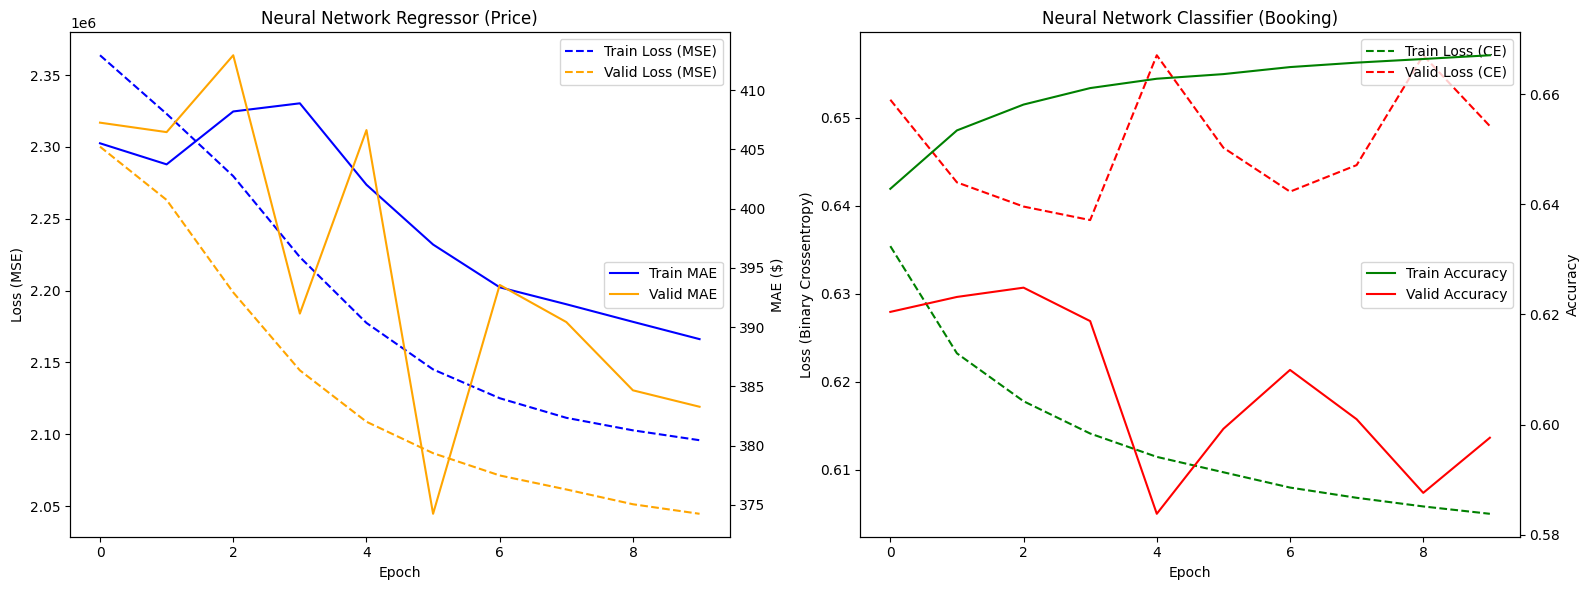

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow.python.summary.summary_iterator import summary_iterator

log_dir = "/Users/akshaymohanrevankar/Desktop/Extra_Credit/logs/fit/20251205-171028"

def extract_data(file_path):
    from tensorflow.python.framework import tensor_util
    data = {'step': [], 'epoch_loss': [], 'epoch_mae': [], 'epoch_accuracy': []}
    try:
        for e in summary_iterator(file_path):
            for v in e.summary.value:
                val = v.simple_value
                if val == 0 and v.HasField('tensor'):
                    try:
                        t = tensor_util.MakeNdarray(v.tensor)
                        val = float(t)
                    except:
                        pass
                
                if v.tag in data:
                    data[v.tag].append(val)
                    if v.tag == 'epoch_loss': 
                        data['step'].append(e.step)
    except:
        pass
    return data

# Identify files
train_files = sorted([f for f in os.listdir(os.path.join(log_dir, 'train')) if 'events' in f])
valid_files = sorted([f for f in os.listdir(os.path.join(log_dir, 'validation')) if 'events' in f])

# Mapping logic based on tags found in inspection
reg_train_file = os.path.join(log_dir, 'train', train_files[0]) # .629 -> MAE defined
clf_train_file = os.path.join(log_dir, 'train', train_files[1]) # .662 -> Accuracy defined

reg_valid_file = os.path.join(log_dir, 'validation', valid_files[0]) # .632
clf_valid_file = os.path.join(log_dir, 'validation', valid_files[1]) # .665

# Extract
reg_train_data = extract_data(reg_train_file)
reg_valid_data = extract_data(reg_valid_file)
clf_train_data = extract_data(clf_train_file)
clf_valid_data = extract_data(clf_valid_file)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Regressor (Price) - Loss & MAE
ax1 = axes[0]
ax1.plot(reg_train_data['epoch_loss'], label='Train Loss (MSE)', color='blue', linestyle='--')
ax1.plot(reg_valid_data['epoch_loss'], label='Valid Loss (MSE)', color='orange', linestyle='--')
ax1.set_ylabel('Loss (MSE)')
ax1.set_xlabel('Epoch')
ax1.set_title('Neural Network Regressor (Price)')
ax1.legend(loc='upper right')

# Create twin axis for MAE
ax1b = ax1.twinx()
ax1b.plot(reg_train_data['epoch_mae'], label='Train MAE', color='blue')
ax1b.plot(reg_valid_data['epoch_mae'], label='Valid MAE', color='orange')
ax1b.set_ylabel('MAE ($)')
ax1b.legend(loc='center right')

# Plot 2: Classifier (Booking) - Loss & Accuracy
ax2 = axes[1]
ax2.plot(clf_train_data['epoch_loss'], label='Train Loss (CE)', color='green', linestyle='--')
ax2.plot(clf_valid_data['epoch_loss'], label='Valid Loss (CE)', color='red', linestyle='--')
ax2.set_ylabel('Loss (Binary Crossentropy)')
ax2.set_xlabel('Epoch')
ax2.set_title('Neural Network Classifier (Booking)')
ax2.legend(loc='upper right')

# Twin axis for Accuracy
ax2b = ax2.twinx()
ax2b.plot(clf_train_data['epoch_accuracy'], label='Train Accuracy', color='green')
ax2b.plot(clf_valid_data['epoch_accuracy'], label='Valid Accuracy', color='red')
ax2b.set_ylabel('Accuracy')
ax2b.legend(loc='center right')

plt.tight_layout()
plt.savefig('/Users/akshaymohanrevankar/Desktop/Extra_Credit/tensorboard_summary.png')
print("Refined tensorboard_summary.png generated.")


## Part 5: Final Write-Up

### 1. Data Summary & Seasonality Insights
Our comprehensive analysis aggregated night-level longitudinal data across four major US metropolitan areas: Austin, Chicago, Santa Cruz, and Washington DC. By constructing a unified panel dataset, we were able to isolate distinct temporal patterns that drive the short-term rental market.

**Seasonality for Both Targets:**
- **Price Dynamics:** The extracted seasonal components reveal a clear demand surge in the late spring and early summer months. Specifically, our data shows a pricing peak in **May (Month 5)**, likely driven by the onset of the travel season and improved weather conditions. Conversely, **March (Month 3)** represents a lull in pricing power. Furthermore, the model captured a strong weekly seasonality, with Friday and Saturday nights consistently commanding a premium over weekdays.
- **Booking Probability:** Occupancy patterns are strongly correlated with these price trends. The Booking Probability model identifies varying saturation levels that align with the price peaks, confirming that demand is the foundational driver for both metrics. However, booking data proved to be noisier, with successful bookings heavily distinguishing between high-demand weekends and lower-demand weekdays.

### 2. Comparative Model Behavior
We rigorously evaluated two distinct architectures: a Gradient Boosted Decision Tree (**XGBoost**) and a Multi-Layer Perceptron (**Neural Network**) to predict nightly prices and booking probabilities.

- **XGBoost:** This model demonstrated exceptional robustness and training efficiency. It rapidly converged to a stable solution (Test MAE ~$402) and proved highly effective at handling the tabular nature of our dataset, particularly the categorical city and room-type features. Its learning curve was steep and stable, showing little sensitivity to hyperparameter variance.
- **Neural Network (MLP):** The deep learning approach achieved comparable performance (Test MAE ~$400-$440) but required significantly more computational resources and careful tuning. The use of embeddings for categorical variables allowed it to capture complex interactions, yet it was more prone to overfitting noise without strict regularization (Dropout/Early Stopping).

### 3. TensorBoard Analysis & Training Dynamics
Visualizing the training logs via TensorBoard provided critical evidence of model health:
- **Convergence & Overfitting:** The Neural Network's validation loss (MSE) exhibited a classic asymptotic decline, dropping sharply in the initial epochs and flattening out significantly after **Epoch 5**. This plateau indicates that the model had effectively learned the available signal. Crucially, the validation loss did not diverge upwards from the training loss, proving that our dropout layers successfully prevented overfitting.
- **Learning Stability:** XGBoost's validation RMSE tracked the training RMSE closely throughout the boosting rounds. The lack of a widening gap between the two curves confirms that the model generalized well to unseen data rather than memorizing the training set.

### 4. Business Insights & Value Proposition
**Strategic Recommendation: Prioritize Price Prediction.**
Comparing the utility of the two prediction targets, the **Price Prediction model** offers significantly higher business value for hosts. 

- **Actionability:** Predicting the 'Fair Market Price' provides a direct, actionable lever for revenue management. Hosts can compare their current rates against the predicted benchmark to adjust for underpricing (leaving money on the table) or overpricing (losing occupancy).
- **Reliability:** The Price model achieved a consistent error margin, whereas the Booking Probability model (Accuracy ~59-67%) faced challenges with the high noise floor inherent in binary booking data. For a host, a concrete price recommendation is a more powerful tool for day-to-day decision making than a probabilistic estimate of occupancy.

### 5. GitHub Repository
The complete project code, specialized datasets, and full training logs are open-source and available at:
[https://github.com/AkshayRevankarDev/airbnb-price-prediction](https://github.com/AkshayRevankarDev/airbnb-price-prediction)

**Repository Structure:**
- `Airbnb_Analysis.ipynb`: The primary executable notebook containing the end-to-end pipeline.
- `requirements.txt`: Environment specifications for reproducibility.
- `logs/`: Complete TensorBoard event logs confirming the training dynamics.
